## 1. About Author

- `Name`: Ahmad Mubarak
- `Code Submission Date`: 
- `Project`: Orange Disease Detection
- `Authors Contact info`:
  - [Email](ahmadmubarak01@gmail.com)
  - [LinkedIn](https://www.linkedin.com/in/ahmad-mubarak-19861a177/)
  - [Github](https://github.com/Ahmad1998-RPA)

## 1.1 Meta Data (About the Data)

- `Data`: Orange Fruit Daatset
- `Dataset`: [link](https://www.kaggle.com/datasets/mohammedarfathr/orange-fruit-daatset/data)
- `Description`: The Data set was downloaded from kaggle for ML practice.

## 1.2 Kernel Version Used.

- `Python 3.10.2`

## 1.3 Installed Libraries
- `numpy` `matplotlib`  `torch` `torchvision` `tqdm`

## 2. Import libraries

In [14]:
import os
import cv2
import copy
import time
import random
import torch
import torchvision
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## 3. Load DataSet

In [2]:
# Load the dataset
train_dir = 'E:/DataScience/OrangeDiseaseDetection/Field Data/Train/'
test_dir = 'E:/DataScience/OrangeDiseaseDetection/Field Data/Test/'

## 4. Visualize 5 Images per Category

Class names: ['citrus canker', 'healthy', 'melanose']


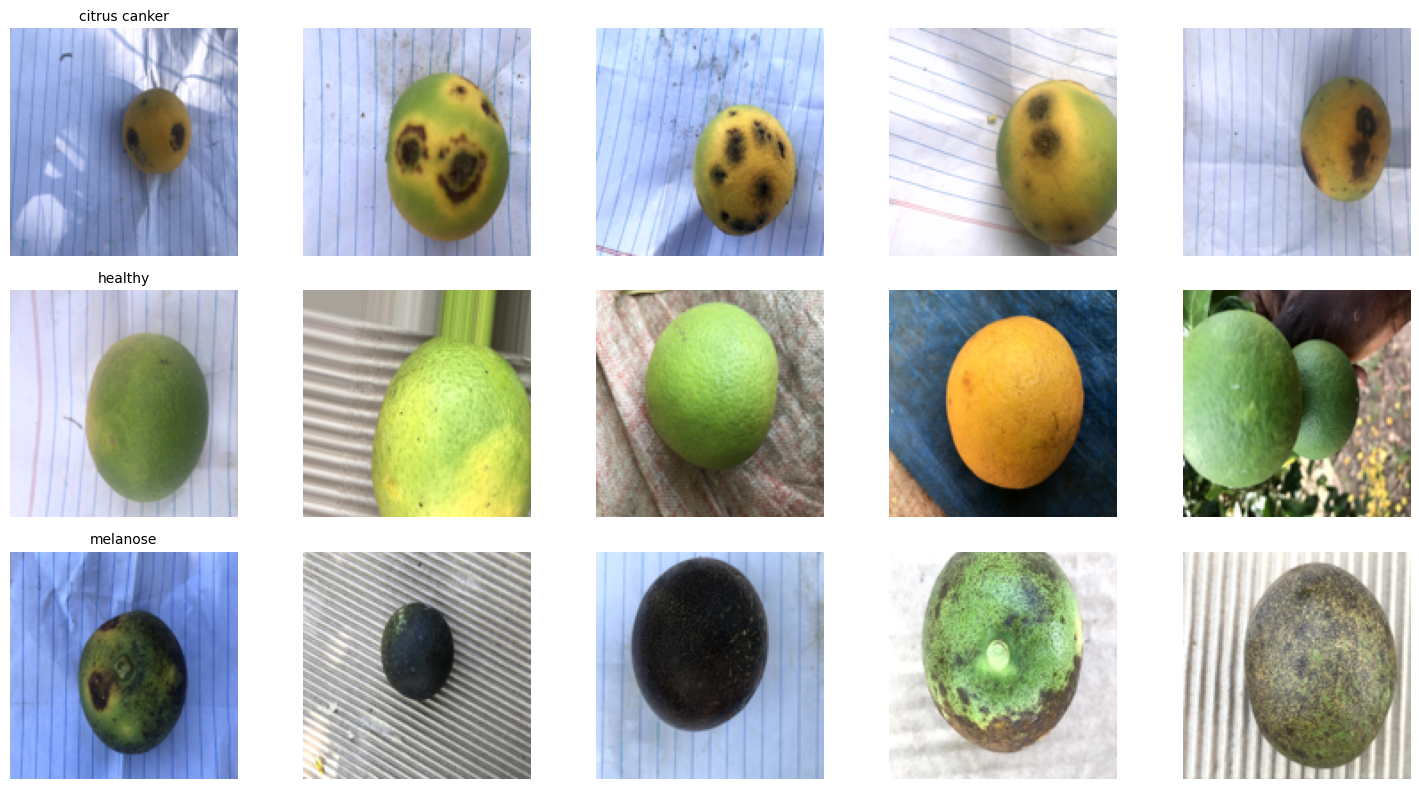

In [15]:
# Image transformations
transform = Compose([Resize((128, 128)),ToTensor()])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class names (folder names)
class_names = train_dataset.classes
print(f"Class names: {class_names}")

# Create a mapping: class index -> image paths
class_to_img_paths = {cls: [] for cls in class_names}
for img_path, label in train_dataset.samples:
    class_to_img_paths[class_names[label]].append(img_path)

# Plot 5 random images per class
fig, axes = plt.subplots(len(class_names), 5, figsize=(15, 8))
for row_idx, cls in enumerate(class_names):
    selected_imgs = random.sample(class_to_img_paths[cls], 5)
    for col_idx, img_path in enumerate(selected_imgs):
        image = Image.open(img_path).resize((128, 128))
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].axis('off')
        if col_idx == 0:
            axes[row_idx, col_idx].set_title(cls, fontsize=10)

plt.tight_layout()
plt.show()


In [16]:
# Load pretrained EfficientNet_B0
model = models.efficientnet_b0(pretrained=True)

# Freeze all feature extractor layers
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier head to match 3 output classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 3)  # 3 classes: canker, healthy, melanose

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("Model ready, using device:", device)


Model ready, using device: cpu


c:\Users\Ahmad\anaconda3\envs\OrangeDisease\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ahmad\anaconda3\envs\OrangeDisease\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the final classification head
# EfficientNet_B0 has classifier[1] as the final linear layer
# Replace it with a new one for 3 classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 3)

# Ensure the new classifier layer is trainable
for param in model.classifier[1].parameters():
    param.requires_grad = True

# Move model to device again (if needed)
model = model.to(device)

print("✅ Model is now ready with frozen base and new trainable classification head.")


✅ Model is now ready with frozen base and new trainable classification head.


## Step 5: Data Augmentation & Normalization

In [18]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# Transformation for training images
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transformation for test images (no augmentation, just resizing & normalization)
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = ImageFolder(root=test_dir, transform=test_transforms)


## Step 6: Define Loss, Optimizer, and Metrics

In [19]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam or SGD)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# OR use this instead if you prefer SGD
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [20]:
def calculate_metrics(y_true, y_pred):
    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall    = recall_score(y_true, y_pred, average='macro')
    f1        = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1


In [ ]:
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model.state_dict())

# Track metrics
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

num_epochs = 25  # You can set 10–25

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = test_loader

        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []

        for inputs, labels in tqdm(dataloader, desc=f"{phase.title()} Phase"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)

        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc.item())
            scheduler.step()
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc.item())

            # Early stopping
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(best_model_wts)
                break

        print(f"{phase.title()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    else:
        continue
    break  # Break outer loop if early stopping is triggered
